<a href="https://colab.research.google.com/github/ccmkaaa/colab/blob/main/dz/dz_viz_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import regex as re
sns.set()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 19,7

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving googleplaystore.csv to googleplaystore.csv
Saving googleplaystore_user_reviews.csv to googleplaystore_user_reviews.csv


In [ ]:
df_apps = pd.read_csv('googleplaystore.csv', index_col=[0])   
df_reviews = pd.read_csv('googleplaystore_user_reviews.csv', index_col=[0]) 

In [ ]:
def clear_apps(df):
  df.drop('Last Updated', axis=1, inplace=True)     # удаляем ненужные столбцы 
  df.drop('Current Ver', axis=1, inplace=True)
  df.drop('Android Ver', axis=1, inplace=True)
  df['Price'] = df.apply(correct_prices, axis=1)
  df['Size'] = df.apply(correct_sizes, axis=1)
  df['Reviews'] = df.apply(correct_reviews, axis=1)
  df['Rating'] = df['Rating'].fillna(0.0) 
  df = df[df['Type'] != '0']                # в столбце Type есть аномальное значение '0', котрое идет в одной строке с аномальной Category '1.9'
  return df

def correct_prices(record):                                 # переводим Prices в numeric-тип
  if record['Price'] == 'Everyone' or record['Price'] == '0':
    return 0.0
  return float(re.search(r'\d+.\d+', record['Price']).group())

def correct_sizes(record):                         # переводим Sizes в одинаковую систему счисления для удобного сравнения
  if record['Size'] == 'Varies with device':
    return 0.0
  elif record['Size'] == '1000+':
    return 1000.0
  dimensions = {'M': 1024, 'k': 1}
  for dim, value in dimensions.items():
    if dim in record['Size']:
      num = record['Size'].replace(dim, '')
      return float(num) * value
  return np.NaN

def correct_reviews(record):                    # переводим Reviews в общий вид для удобного сравнения
  dimensions = {'M': 100000}
  for dim, value in dimensions.items():
    if dim in record['Reviews']:
      num = record['Reviews'].replace(dim, '')
      return float(num) * value
  return float(record['Reviews'])

def correct_types(record):    # not used
  if type(record['Type']) is not str:
    return 'None'
  return record['Type']

def correct_categories(record):   # not used
  if type(record['Category']) is not str:
    return 'None'
  return record['Category']

In [ ]:
def clear_reviews(df):                        # df_reviews не используется, так что эта функция пуста
  return df

In [ ]:
df_apps = clear_apps(df_apps)                         # очистка df с приложениями
df_reviews = clear_reviews(df_reviews)

In [ ]:
types_count = df_apps.groupby(['Type'])['Type'].count().reset_index(name='count_apps')

,Type,count_apps
0,Free,10039
1,Paid,800


***Большей популярностью пользуются бесплатные приложения***

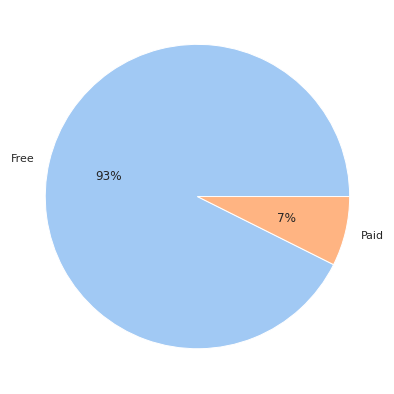

In [ ]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(types_count['count_apps'].unique(), colors=colors, labels=types_count['Type'].unique(), autopct='%0.0f%%')
plt.show()

In [ ]:
top_categories = df_apps.groupby(['Category'])['Installs'].count().reset_index(name='count_apps').sort_values(by='count_apps', ascending=False).head(10)

***Среди категорий больше всего приложений в 'Family'***

In [ ]:
top_categories.style.bar(align='mid', color='Green')

,Category,count_apps
11,FAMILY,1972
14,GAME,1144
29,TOOLS,843
20,MEDICAL,463
4,BUSINESS,460
25,PRODUCTIVITY,424
23,PERSONALIZATION,392
6,COMMUNICATION,387
28,SPORTS,384
18,LIFESTYLE,382


**В категории Game больше всего подростков (кроме того, они социальнее остальных по категории Social)**

**Dating приложениями пользуются чаще люди старше 17 лет**

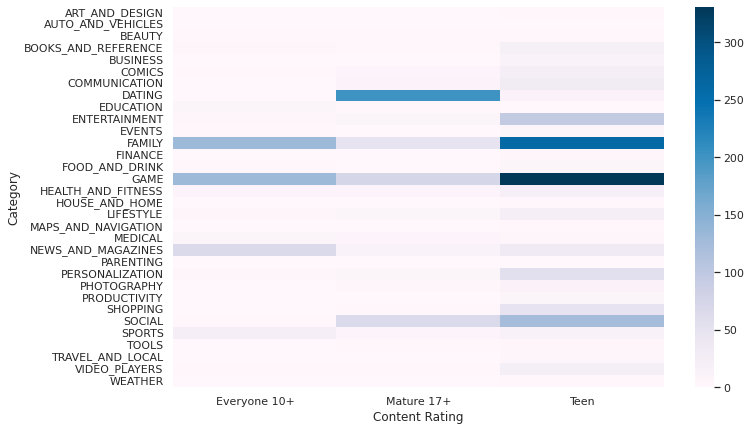

In [ ]:
categories = df_apps[~df_apps['Content Rating'].isin(['Everyone', 'Unrated', 'Adults only 18+'])]      # исключаем непопулярные или слишком популярные Content Rating
categories = categories.groupby(['Category', 'Content Rating'])['Installs'].count().reset_index(name='count_apps').sort_values(by='count_apps', ascending=False)
categories = categories.pivot_table(
    index='Category',
    columns='Content Rating',
    values='count_apps',
    aggfunc=sum
).fillna(0.0)

sns.heatmap(categories, cmap='PuBu')

***Разброс оценок среди топ-10 категорий***

**Наибольший разброс среди Buisness-приложений (Возможно среди них много SCAM-приложений или они платные и не оправдывают цену за функционал)**




**Наименьший разброс значения у игр (т.к. контент развлекательный)**

**Медианные значения +- у всех одинаковые (как и средние)**

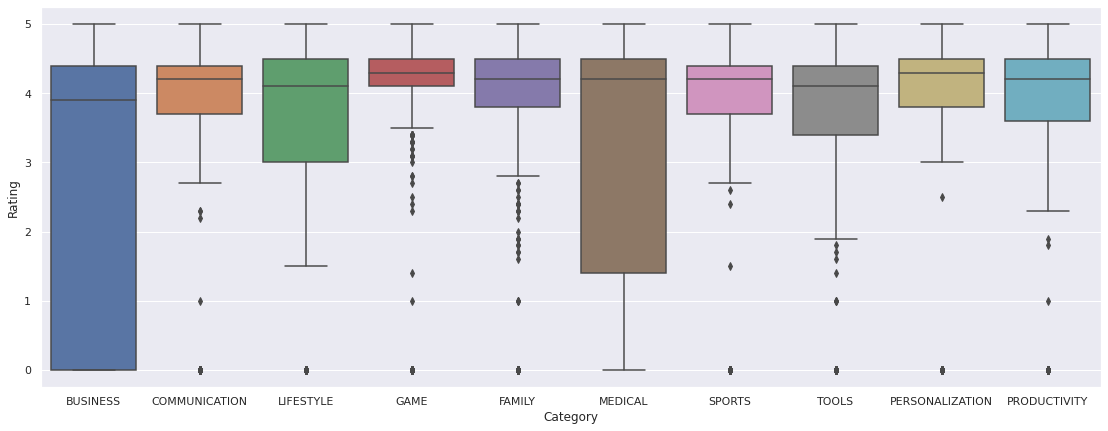

In [ ]:
#avg_rating_per_cat = df_apps.groupby(['Category'])['Rating'].mean().reset_index(name='avg_rating')               # avg значения
sns.boxplot(x='Category', y='Rating', data=df_apps[df_apps['Category'].isin(top_categories['Category'])])        # разброс оценок топ 10 категорий